# Classfication Network Architecture

BatchNorm has some issue in tf2.0. The github issues say that the behaviour has changed and we need to be mindful of the flag `training:False | True`. This notebook attempts to figure out how to get BN to work in TF 2.x.

In my previous notebooks, I have had dismal performance whenever I used BN.

@date: 02-Sep-2020 | @author: katnoria

In [46]:
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras import Model

In [9]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [10]:
print("Version Used in this Notebook:")
version_info(tf)
version_info(tfds)

Version Used in this Notebook:
tensorflow: 2.3.0
tensorflow_datasets: 3.2.1


In [11]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


# Dataset

Tensorflow Datasets already provides this dataset in a format that we can use out of the box.

In [13]:
# Load the dataset
(ds_train, ds_test), metadata = tfds.load(
    'cifar10', split=['train', 'test'], shuffle_files=True, 
    with_info=True, as_supervised=True
)

In [14]:
len(ds_train), len(ds_test), metadata.features['label'].num_classes

(50000, 10000, 10)

Use the built in function to visualise the dataset 

In [15]:
# Review metadata
# See https://www.tensorflow.org/datasets/overview
metadata.features

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [16]:
NUM_CLASSES = metadata.features["label"].num_classes

num_train_examples = len(ds_train)
num_test_examples = len(ds_test)
print(f"Training dataset size: {num_train_examples}")
print(f"Test dataset size: {num_test_examples}")

Training dataset size: 50000
Test dataset size: 10000


### Training Pipeline

In [17]:
IMG_SIZE = 32
BATCH_SIZE = 256


def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
#     image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image / 255., label

In [18]:
train_ds = ds_train.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .cache() \
    .shuffle(num_train_examples).batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [19]:
example = ds_train.take(1)

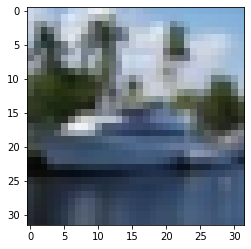

In [20]:
for images, labels in example:
    plt.imshow(images)

### Evaluation Pipeline

In [21]:
test_ds = ds_test.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .cache() \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

# Build Model

We now build a simple convolution neural network

# Use Pretrained Models

Instead of training the full model, it is generally a good practice to use a pretrained network as a base model and add your layers on top. 
This allows us to reduce the training times and leverage on what base model has learned.

In [22]:
IMG_SIZE = 32
BATCH_SIZE = 128

Do not use the preprocessing we were using earlier, because we now use a pre-trained network as our feature extractor.

In [23]:
train_ds = ds_train \
    .cache() \
    .shuffle(num_train_examples).batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [24]:
example = ds_train.take(1)

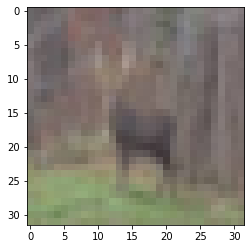

In [25]:
for images, labels in example:
    plt.imshow(images)

### Evaluation Pipeline

In [60]:
test_ds = ds_test \
    .cache() \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

# Model 1: Resnet50 + GAP + BN + DENSE

In [27]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False

In [41]:
def get_pretrained_model(base_model):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model

In [53]:
resnet_model = get_pretrained_model(base_model)
resnet_model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice_4  [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd_4 (Tenso [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [54]:
# a higher learning rate for BN
lr = 1e-2
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, update_freq='epoch', profile_batch=2
)

In [55]:
resnet_model.evaluate(test_ds)

78/78 [==============================] - 1s 12ms/step - loss: 4.9519 - accuracy: 0.1133


[4.951874732971191, 0.11328125]

In [56]:
# We are going to train for 50 epochs
history = resnet_model.fit(
    train_ds, epochs=200, validation_data=test_ds, 
    callbacks=[reduce_lr, tb_callback]
)

Epoch 1/200
  2/390 [..............................] - ETA: 1:10 - loss: 2.8645 - accuracy: 0.2656WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0118s vs `on_train_batch_end` time: 0.3508s). Check your callbacks.


390/390 [==============================] - 6s 15ms/step - loss: 1.2871 - accuracy: 0.5824 - val_loss: 1.1245 - val_accuracy: 0.6148
Epoch 2/200
390/390 [==============================] - 6s 14ms/step - loss: 1.0319 - accuracy: 0.6449 - val_loss: 1.0881 - val_accuracy: 0.6359
Epoch 3/200
390/390 [==============================] - 5s 14ms/step - loss: 0.9510 - accuracy: 0.6708 - val_loss: 1.0954 - val_accuracy: 0.6336
Epoch 4/200
390/390 [==============================] - 5s 14ms/step - loss: 0.8878 - accuracy: 0.6941 - val_loss: 1.1245 - val_accuracy: 0.6340
Epoch 5/200
390/390 [==============================] - 6s 14ms/step - loss: 0.8471 - accuracy: 0.7064 - val_loss: 1.2138 - val_accuracy: 0.6289
Epoch 6/200
390/390 [==============================] - 6s 14ms/step - loss: 0.8082 - accuracy: 0.7206 - val_loss: 1.1524 - val_accuracy: 0.6410
Epoch 7/200
390/390 [==============================] - 6s 14ms/step - loss: 0.7673 - accuracy: 0.7335 - val_loss: 1.2191 - val_accuracy: 0.6240
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



390/390 [==============================] - 6s 14ms/step - loss: 0.0227 - accuracy: 0.9924 - val_loss: 4.8536 - val_accuracy: 0.6302
Epoch 198/200
390/390 [==============================] - 5s 14ms/step - loss: 0.0239 - accuracy: 0.9924 - val_loss: 4.8401 - val_accuracy: 0.6305
Epoch 199/200
390/390 [==============================] - 6s 14ms/step - loss: 0.0235 - accuracy: 0.9927 - val_loss: 4.9802 - val_accuracy: 0.6312
Epoch 200/200
390/390 [==============================] - 6s 14ms/step - loss: 0.0220 - accuracy: 0.9930 - val_loss: 4.9854 - val_accuracy: 0.6364


### Plot the plots

In [34]:
def plot_history(history):
    plt.style.use('seaborn')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))    

    ax1.plot(acc, label="Training Accuracy")
    ax1.plot(val_acc, label="Validation Accuracy")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')    
    ax1.legend(loc='lower right')
    ax1.set_title("Training and Validation Accuracy")
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax2.plot(loss, label="Training Loss")
    ax2.plot(val_loss, label="Validation Loss")
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')    
    ax2.legend(loc='upper right')
    ax2.set_title("Training and Validation Loss")
    
    plt.show()

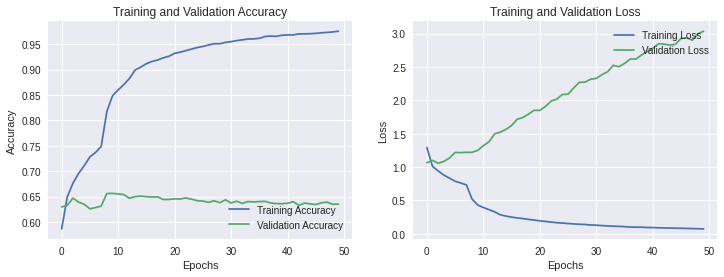

In [35]:
plot_history(history)

# Model 2: Remove Dense Layers

Our model is overfitting so we can try to reduce the capacity of our network

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False

In [57]:
def get_pretrained_model_no_dense(base_model):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model

In [58]:
resnet_no_dense_model = get_pretrained_model_no_dense(base_model)
resnet_no_dense_model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice_5  [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd_5 (Tenso [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_8 (Dense)              (None, 10)              

In [59]:
# a higher learning rate for BN
lr = 1e-2
resnet_no_dense_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, update_freq='epoch', profile_batch=2
)

# We are going to train for 50 epochs
history = resnet_no_dense_model.fit(
    train_ds, epochs=200, validation_data=test_ds, 
    callbacks=[reduce_lr, tb_callback]
)

Epoch 1/200
  2/390 [..............................] - ETA: 36s - loss: 2.6398 - accuracy: 0.2031WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0133s vs `on_train_batch_end` time: 0.1724s). Check your callbacks.


390/390 [==============================] - 6s 16ms/step - loss: 1.6202 - accuracy: 0.5767 - val_loss: 1.1804 - val_accuracy: 0.6278
Epoch 2/200
390/390 [==============================] - 5s 14ms/step - loss: 1.0436 - accuracy: 0.6491 - val_loss: 1.0515 - val_accuracy: 0.6416
Epoch 3/200
390/390 [==============================] - 5s 14ms/step - loss: 0.9816 - accuracy: 0.6599 - val_loss: 1.0674 - val_accuracy: 0.6349
Epoch 4/200
390/390 [==============================] - 6s 14ms/step - loss: 0.9757 - accuracy: 0.6607 - val_loss: 1.0504 - val_accuracy: 0.6379
Epoch 5/200
390/390 [==============================] - 5s 14ms/step - loss: 0.9729 - accuracy: 0.6628 - val_loss: 1.0537 - val_accuracy: 0.6371
Epoch 6/200
390/390 [==============================] - 5s 14ms/step - loss: 0.9726 - accuracy: 0.6613 - val_loss: 1.0206 - val_accuracy: 0.6497
Epoch 7/200
390/390 [==============================] - 5s 14ms/step - loss: 0.9771 - accuracy: 0.6594 - val_loss: 1.0454 - val_accuracy: 0.6422
Epoc

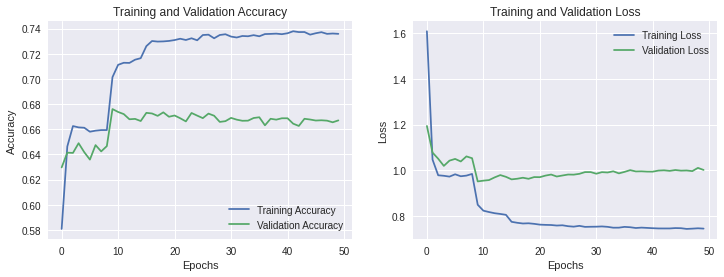

In [40]:
plot_history(history)

# Model 3: Add some capacity

Looks better than 1st model but we can perhaps add capacity

In [61]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False
def get_pretrained_model_dense(base_model, size):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(size, activation='relu')(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model
resnet_dense_model = get_pretrained_model_dense(base_model, 64)
resnet_dense_model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice_6  [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd_6 (Tenso [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_9 (Dense)              (None, 64)              

In [62]:
# a higher learning rate for BN
lr = 1e-2
resnet_dense_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, update_freq='epoch', profile_batch=2
)

# We are going to train for 50 epochs
history = resnet_dense_model.fit(
    train_ds, epochs=200, validation_data=test_ds, 
    callbacks=[reduce_lr, tb_callback]
)

Epoch 1/200
  2/390 [..............................] - ETA: 46s - loss: 2.7405 - accuracy: 0.2344WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0104s vs `on_train_batch_end` time: 0.2291s). Check your callbacks.


390/390 [==============================] - 7s 17ms/step - loss: 1.2451 - accuracy: 0.5873 - val_loss: 1.0947 - val_accuracy: 0.6281
Epoch 2/200
390/390 [==============================] - 5s 14ms/step - loss: 1.0170 - accuracy: 0.6499 - val_loss: 1.0700 - val_accuracy: 0.6366
Epoch 3/200
390/390 [==============================] - 6s 14ms/step - loss: 0.9406 - accuracy: 0.6760 - val_loss: 1.0825 - val_accuracy: 0.6463
Epoch 4/200
390/390 [==============================] - 6s 14ms/step - loss: 0.9012 - accuracy: 0.6897 - val_loss: 1.1155 - val_accuracy: 0.6338
Epoch 5/200
390/390 [==============================] - 5s 14ms/step - loss: 0.8687 - accuracy: 0.6993 - val_loss: 1.1106 - val_accuracy: 0.6452
Epoch 6/200
390/390 [==============================] - 6s 14ms/step - loss: 0.8324 - accuracy: 0.7102 - val_loss: 1.1546 - val_accuracy: 0.6399
Epoch 7/200
390/390 [==============================] - 6s 14ms/step - loss: 0.8041 - accuracy: 0.7216 - val_loss: 1.1431 - val_accuracy: 0.6361
Epoc

# Model 4: Resnet50 + GAP + BN + Dense + Dropout

Add dropout to the model

In [63]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False
def get_pretrained_model_dense(base_model, size, drop=0.2):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(drop)(x)
    x = Dense(size, activation='relu')(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model
resnet_dense_do_model = get_pretrained_model_dense(base_model, 64)
resnet_dense_do_model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice_7  [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd_7 (Tenso [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)            

In [64]:
# a higher learning rate for BN
lr = 1e-2
resnet_dense_do_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%dDropoutM%S")
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, update_freq='epoch', profile_batch=2
)

# We are going to train for 50 epochs
history = resnet_dense_do_model.fit(
    train_ds, epochs=200, validation_data=test_ds, 
    callbacks=[reduce_lr, tb_callback]
)

Epoch 1/200
  2/390 [..............................] - ETA: 46s - loss: 2.8400 - accuracy: 0.1836WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.2214s). Check your callbacks.


390/390 [==============================] - 6s 17ms/step - loss: 1.2971 - accuracy: 0.5721 - val_loss: 1.0964 - val_accuracy: 0.6187
Epoch 2/200
390/390 [==============================] - 6s 14ms/step - loss: 1.0757 - accuracy: 0.6271 - val_loss: 1.0455 - val_accuracy: 0.6398
Epoch 3/200
390/390 [==============================] - 6s 14ms/step - loss: 1.0176 - accuracy: 0.6475 - val_loss: 1.0752 - val_accuracy: 0.6285
Epoch 4/200
390/390 [==============================] - 5s 14ms/step - loss: 0.9974 - accuracy: 0.6565 - val_loss: 1.0881 - val_accuracy: 0.6312
Epoch 5/200
390/390 [==============================] - 5s 14ms/step - loss: 0.9726 - accuracy: 0.6632 - val_loss: 1.0363 - val_accuracy: 0.6484
Epoch 6/200
390/390 [==============================] - 6s 14ms/step - loss: 0.9590 - accuracy: 0.6695 - val_loss: 1.0935 - val_accuracy: 0.6326
Epoch 7/200
390/390 [==============================] - 6s 14ms/step - loss: 0.9417 - accuracy: 0.6757 - val_loss: 1.0896 - val_accuracy: 0.6360
Epoc

# Model 5: Model2 + Dropout

Add dropout to model 2

In [68]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False
def get_model_5(base_model, drop=0.2):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(drop)(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model
model5 = get_model_5(base_model, 0.2)
model5.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice_9  [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd_9 (Tenso [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)            

In [ ]:
# a higher learning rate for BN
lr = 1e-2
model5.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%dDropoutM%S")
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, update_freq='epoch', profile_batch=2
)

# We are going to train for 50 epochs
history = model5.fit(
    train_ds, epochs=200, validation_data=test_ds, 
    callbacks=[reduce_lr, tb_callback]
)

Epoch 1/200
  2/390 [..............................] - ETA: 46s - loss: 2.8400 - accuracy: 0.1836WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.2214s). Check your callbacks.


390/390 [==============================] - 6s 17ms/step - loss: 1.2971 - accuracy: 0.5721 - val_loss: 1.0964 - val_accuracy: 0.6187
Epoch 2/200
390/390 [==============================] - 6s 14ms/step - loss: 1.0757 - accuracy: 0.6271 - val_loss: 1.0455 - val_accuracy: 0.6398
Epoch 3/200
390/390 [==============================] - 6s 14ms/step - loss: 1.0176 - accuracy: 0.6475 - val_loss: 1.0752 - val_accuracy: 0.6285
Epoch 4/200
390/390 [==============================] - 5s 14ms/step - loss: 0.9974 - accuracy: 0.6565 - val_loss: 1.0881 - val_accuracy: 0.6312
Epoch 5/200
390/390 [==============================] - 5s 14ms/step - loss: 0.9726 - accuracy: 0.6632 - val_loss: 1.0363 - val_accuracy: 0.6484
Epoch 6/200
390/390 [==============================] - 6s 14ms/step - loss: 0.9590 - accuracy: 0.6695 - val_loss: 1.0935 - val_accuracy: 0.6326
Epoch 7/200
390/390 [==============================] - 6s 14ms/step - loss: 0.9417 - accuracy: 0.6757 - val_loss: 1.0896 - val_accuracy: 0.6360
Epoc

# Model 6: moar dropout

In [69]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False
model6 = get_model_5(base_model, 0.4)
model6.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice_10 [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd_10 (Tens [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)            

In [70]:
# a higher learning rate for BN
lr = 1e-2
model6.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%M%S-model6")
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, update_freq='epoch', profile_batch=2
)

# We are going to train for 50 epochs
history = model6.fit(
    train_ds, epochs=200, validation_data=test_ds, 
    callbacks=[reduce_lr, tb_callback]
)

Epoch 1/200
  2/390 [..............................] - ETA: 51s - loss: 2.9598 - accuracy: 0.1992WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.2499s). Check your callbacks.


390/390 [==============================] - 6s 17ms/step - loss: 2.0632 - accuracy: 0.5269 - val_loss: 1.2440 - val_accuracy: 0.6077
Epoch 2/200
390/390 [==============================] - 5s 14ms/step - loss: 1.2407 - accuracy: 0.5912 - val_loss: 1.0402 - val_accuracy: 0.6391
Epoch 3/200
390/390 [==============================] - 5s 14ms/step - loss: 1.1272 - accuracy: 0.6077 - val_loss: 1.0194 - val_accuracy: 0.6413
Epoch 4/200
390/390 [==============================] - 5s 14ms/step - loss: 1.1273 - accuracy: 0.6056 - val_loss: 1.0940 - val_accuracy: 0.6177
Epoch 5/200
390/390 [==============================] - 5s 14ms/step - loss: 1.1359 - accuracy: 0.6022 - val_loss: 1.0969 - val_accuracy: 0.6182
Epoch 6/200
390/390 [==============================] - 5s 14ms/step - loss: 1.1533 - accuracy: 0.6027 - val_loss: 1.0603 - val_accuracy: 0.6255
Epoch 7/200
390/390 [==============================] - 5s 14ms/step - loss: 1.1514 - accuracy: 0.6024 - val_loss: 1.0560 - val_accuracy: 0.6326
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



390/390 [==============================] - 5s 14ms/step - loss: 0.9647 - accuracy: 0.6618 - val_loss: 0.9521 - val_accuracy: 0.6705
Epoch 187/200
390/390 [==============================] - 5s 14ms/step - loss: 0.9584 - accuracy: 0.6631 - val_loss: 0.9548 - val_accuracy: 0.6684
Epoch 188/200
390/390 [==============================] - 5s 14ms/step - loss: 0.9579 - accuracy: 0.6641 - val_loss: 0.9437 - val_accuracy: 0.6717
Epoch 189/200
390/390 [==============================] - 5s 14ms/step - loss: 0.9603 - accuracy: 0.6632 - val_loss: 0.9442 - val_accuracy: 0.6706
Epoch 190/200
390/390 [==============================] - 5s 14ms/step - loss: 0.9665 - accuracy: 0.6598 - val_loss: 0.9504 - val_accuracy: 0.6734
Epoch 191/200
390/390 [==============================] - 5s 14ms/step - loss: 0.9575 - accuracy: 0.6623 - val_loss: 0.9458 - val_accuracy: 0.6726
Epoch 192/200
390/390 [==============================] - 5s 14ms/step - loss: 0.9631 - accuracy: 0.6632 - val_loss: 0.9466 - val_accuracy:

In [71]:
model6.evaluate(test_ds)

78/78 [==============================] - 1s 12ms/step - loss: 0.9530 - accuracy: 0.6670


[0.9530342221260071, 0.6669671535491943]

# Model 7:  model 1 + dropout

In [72]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False
def get_model_7(base_model, drop=0.2):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(drop)(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model
model7 = get_model_7(base_model, 0.4)
model7.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice_11 [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd_11 (Tens [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_15 (Dense)             (None, 128)             

In [73]:
# a higher learning rate for BN
lr = 1e-2
model7.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%M%S-model7")
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, update_freq='epoch', profile_batch=2
)

# We are going to train for 50 epochs
history = model7.fit(
    train_ds, epochs=200, validation_data=test_ds, 
    callbacks=[reduce_lr, tb_callback]
)

Epoch 1/200
  2/390 [..............................] - ETA: 48s - loss: 2.8815 - accuracy: 0.2773WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0101s vs `on_train_batch_end` time: 0.2380s). Check your callbacks.


390/390 [==============================] - 6s 17ms/step - loss: 1.5033 - accuracy: 0.5285 - val_loss: 1.1652 - val_accuracy: 0.5930
Epoch 2/200
390/390 [==============================] - 6s 14ms/step - loss: 1.2523 - accuracy: 0.5761 - val_loss: 1.1345 - val_accuracy: 0.6172
Epoch 3/200
390/390 [==============================] - 6s 14ms/step - loss: 1.1743 - accuracy: 0.6004 - val_loss: 1.0862 - val_accuracy: 0.6282
Epoch 4/200
390/390 [==============================] - 6s 14ms/step - loss: 1.1362 - accuracy: 0.6149 - val_loss: 1.0845 - val_accuracy: 0.6424
Epoch 5/200
390/390 [==============================] - 6s 14ms/step - loss: 1.1123 - accuracy: 0.6216 - val_loss: 1.1013 - val_accuracy: 0.6305
Epoch 6/200
390/390 [==============================] - 6s 14ms/step - loss: 1.0993 - accuracy: 0.6268 - val_loss: 1.0875 - val_accuracy: 0.6355
Epoch 7/200
390/390 [==============================] - 6s 14ms/step - loss: 1.0855 - accuracy: 0.6307 - val_loss: 1.0698 - val_accuracy: 0.6470
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [74]:
model7.evaluate(test_ds)

78/78 [==============================] - 1s 12ms/step - loss: 1.9338 - accuracy: 0.6594


[1.933787226676941, 0.6593549847602844]